In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import random
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from io import BytesIO
from datasets import load_dataset

I have taken VGG16 model from TorchVision library  and  the code initializes a VGG16 model with pretrained weights. 'IMAGENET1K_V1' parameter says that the model should be loaded with weights pretrained on ImageNet dataset.

In [2]:
model = models.vgg16(weights='IMAGENET1K_V1')
model = model.eval()

1. The code is now initializing the device meaning the model will run on either CUDA enabled GPU or on CPU.
2. Now we are loading the dataset from the link provided in the Assignment. Post that we are selecting random image from the dataset.

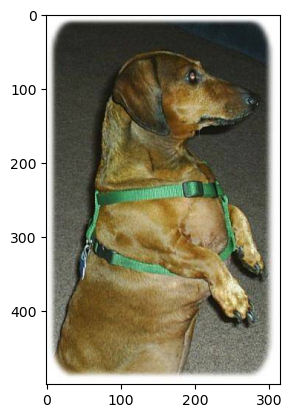

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the dataset
dataset = load_dataset("pantelism/cats-vs-dogs", split='train')

# Select a random image
random_index = random.randint(0, len(dataset) - 1)
sample = dataset[random_index]

image = sample['image']  # This will be a PIL Image
label = sample['label']

# Convert to array for display
img_data = np.asarray(image)
plt.imshow(image)
plt.show()

Now we are doing normalization. After normalization we are resizing the image to 224 X 224 pixels and then converting to tensor. Finally we are adding batch dimension to the image tensor.

In [4]:
# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )
transform = transforms.Compose([
 transforms.Resize((224,224)),
 transforms.ToTensor(),
])

transform_img = transform(image)
input_img = transform_normalize(transform_img)
input_img = input_img.unsqueeze(0).to(device)

This is prediction stage:
1. We are intializing predicted label with predicted class index (from ImageNet).
2. Now wer are setting cat and dog indices
3. Then we are checking if prediction_label is od cat_indices or dog_indices.
4. Post that we are checking probablity scores and accordingly printing the results.

In [5]:
# Perform the prediction
with torch.no_grad():
    output = model(input_img)

# Get the predicted class index (out of 1000 ImageNet classes)
_, predicted_idx = torch.max(output, 1)
predicted_label = predicted_idx.item()

# ImageNet indices for cat and dog
cat_indices = [281, 282, 283, 284, 285]  # Various cat breeds
dog_indices = list(range(151, 269))  # Various dog breeds

# Map the prediction to cat or dog
if predicted_label in cat_indices:
    predicted_class = "cat"
elif predicted_label in dog_indices:
    predicted_class = "dog"
else:
    predicted_class = "unknown"

# Get the probability scores for cat and dog classes
cat_prob = sum(output[0][i].item() for i in cat_indices)
dog_prob = sum(output[0][i].item() for i in dog_indices)
total_prob = cat_prob + dog_prob
cat_prob /= total_prob
dog_prob /= total_prob

# Print the results
class_names = ['cat', 'dog']
print(f"Actual class: {class_names[label]}")
print(f"Predicted class: {predicted_class}")
print(f"Probability of cat: {cat_prob:.4f}")
print(f"Probability of dog: {dog_prob:.4f}")

Actual class: dog
Predicted class: dog
Probability of cat: 0.0065
Probability of dog: 0.9935


Integrated Gradients:
1. Initialize Integrated Gradients algorithm with pre-trained model.
2. Integrated Gradients method computes integral of gradients along a straightline path form a baseline input to actual input.
3. This path integral is approximated using a summation with n_steps.

In [6]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to 
attributions_ig = integrated_gradients.attribute(input_img, target=predicted_label, n_steps=200)

Now we are doing visualization:
1. For visualization Captum is used since it gives a helpful representation of the importance map.

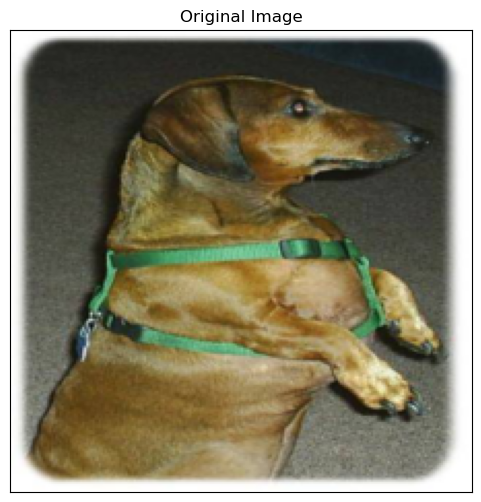

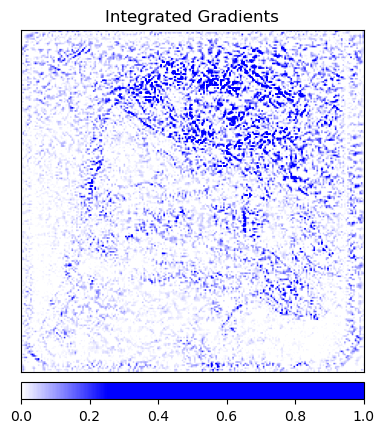

In [7]:

viz.visualize_image_attr(None, np.transpose(transform_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)


viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                        np.transpose(transform_img.squeeze().cpu().detach().numpy(), (1,2,0)), method='heat_map', cmap=default_cmap, 
                        show_colorbar=True, sign='positive', plt_fig_axis=(plt.gcf(), plt.gca()),
                        title='Integrated Gradients')

plt.show()

Grad-CAM:
1. Here first I am finding Convolution Layer.
2. Then I am initializing Grad-CAM
3. Post that I am getting Predicted Class because it determines the class predicted by the model for the input image.
4. Then computation of Grad-CAM attributes take place for predicted class

In [8]:
last_conv_layer = None
for module in model.features.modules():
    if isinstance(module, torch.nn.Conv2d):
        last_conv_layer = module

layer_gradcam = LayerGradCam(model, last_conv_layer)
# Get the predicted class
_, predicted_idx = torch.max(output, 1)
pred_label_idx = predicted_idx.item()

# Compute attributions for the predicted class
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

Visualization of Grad-CAM is taking place in this stage

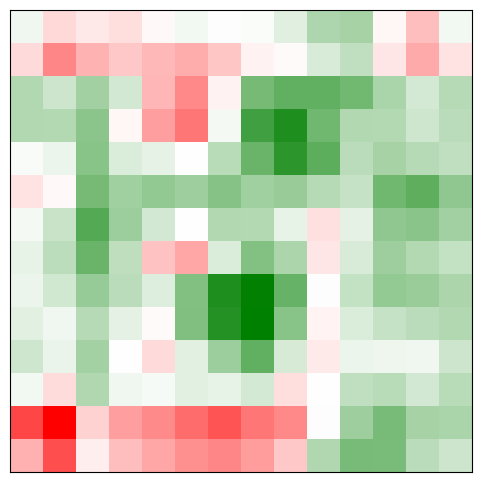

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [25]:
viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all")

1. Firstly we are unsampling the Grad-CAM attributions to match the size of the input image.
2. Then printing the shapes of the original attributions, upsampled attributions, and input image for comparison.
3. Lastly Visualization is done.

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


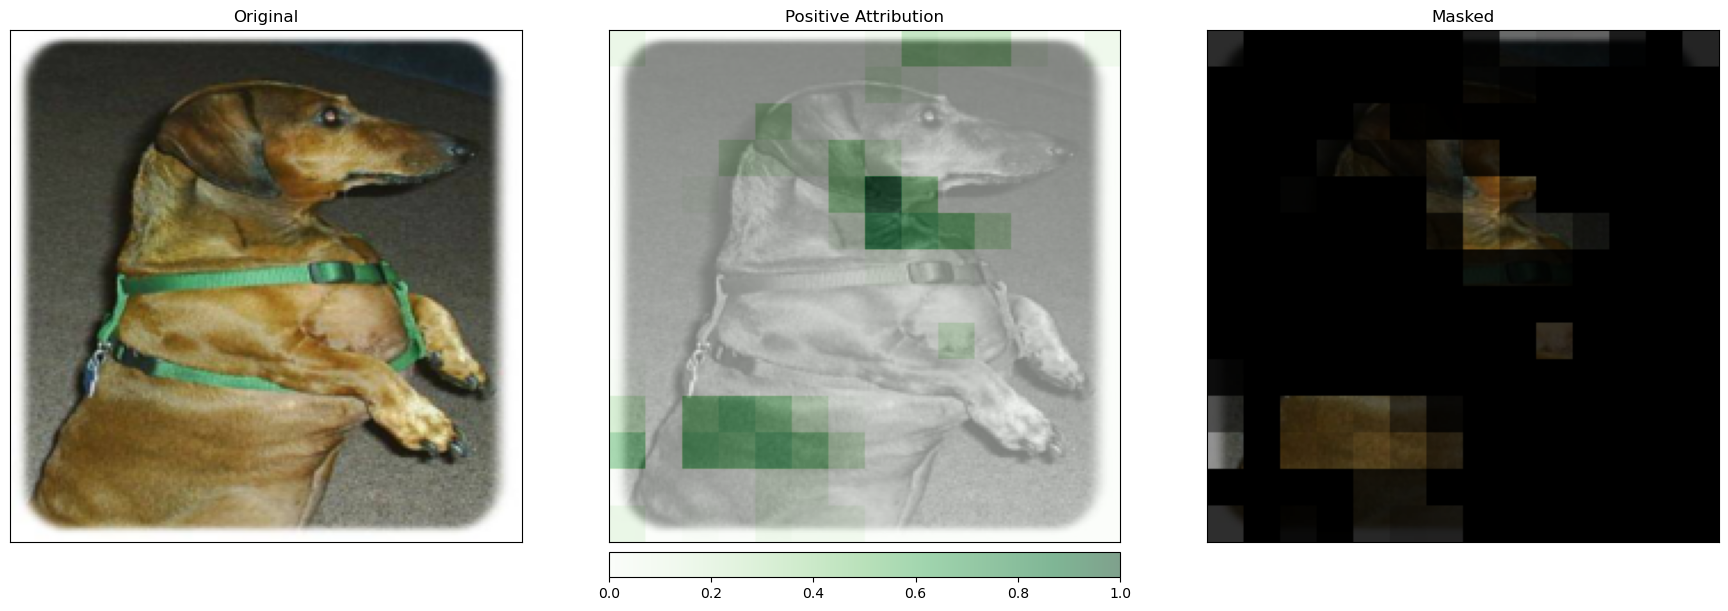

In [9]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transform_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))